Problemas en el método del gradiente descendente
===

* 30:00 min | Última modificación: Mayo 25, 2021 | [YouTube]

## Algoritmo

El método del gradiente descendente usa la ecuación de corrección o mejora:
$$
\mathbf{x}_k = \mathbf{x}_{k-1} - \mu \frac{\partial}{ \partial \mathbf{x}} f(\mathbf{x}_{k-1})
$$
donde $\mu$ es la tasa o factor de aprendizaje.

## Definición del problema

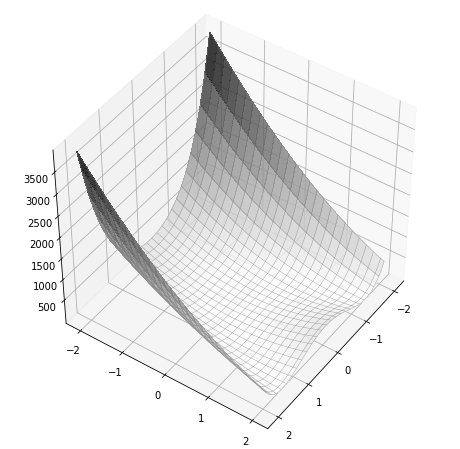

In [1]:
#
# Para ejemplificar su uso, buscará el punto de mínima de
# la función de Rosenbrock de dos dimensiones. El punto de
# mínima es f(1, 1) = 0. La región de búsqueda es
#
#    -2.048 < x, y < 2.048
#
# A continuación se gráfica la función y su contorno para
# el caso de 2 dimensiones.
#
from EOS.benchmarks import Rosenbrock

fn = Rosenbrock(n_dim=2)
fn.plot_surface()

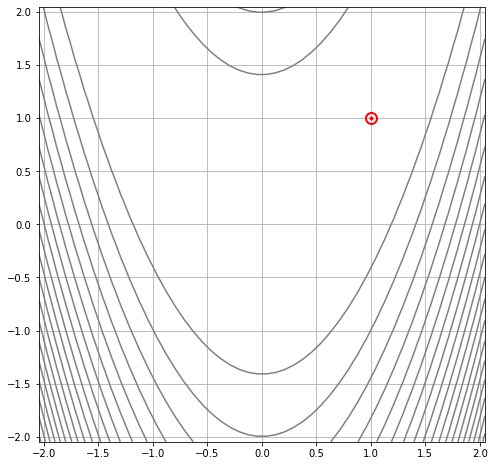

In [2]:
#
# El punto rojo indica el mínimo de la función
#
fn.plot_contour()

## Implementación

In [3]:
#
# El método del gradiente descendente aprovecha la
# información local que entrega el punto actual para
# generar una aproximación mejor al mínimo.
#

#
# Se crea una instancia del geneador para crear poblaciones
# de una sola solución.
#
from EAOS.generators import RandomUniform

POPSIZE = 1

monte_carlo = RandomUniform(
    pop_size=POPSIZE,
    low=fn.LB,
    high=fn.UB,
    seed = 123456,
)

#
# Se crea la población de soluciones
#
solutions = monte_carlo()
solutions[:]

[{'x': array([ 0.55916032, -0.47181142]), 'fn_x': None}]

In [4]:
#
# Se crea una instancia del optimizador. Cada llamada
# realiza una sola iteración del método del gradiente
# descendente.
#
from EAOS.algorithms import GradientDescendent

optimizer = GradientDescendent(fn=fn, learning_rate=0.0001)

In [5]:
#
# Se instancia un monitor para computar las estadísticas de
# la corrida
#
from EAOS.monitor import Monitor

monitor = Monitor()

In [6]:
#
# Se realizan NITER iteraciones del algoritmo de gradiente
# descendente
#
NITER = 50

for iter in range(NITER):
    #
    # El único individuo existente tiene indice 0
    #
    solutions = optimizer(solutions)

    #
    # Se computan las estadísticas de la población actual
    #
    monitor(solutions)

#
# El monitor almacena la mejor solución encontrada
#
monitor.global_x_opt, monitor.global_fn_x_opt

(array([ 0.26598495, -0.09553928]), 3.303923808178889)

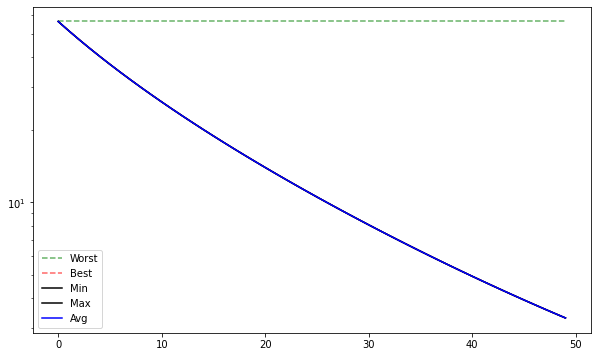

In [7]:
monitor.plot_stats()

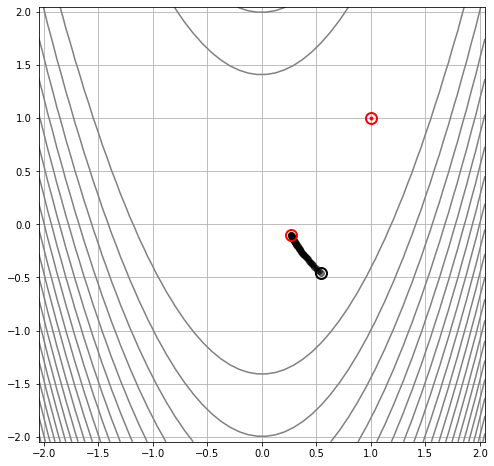

In [8]:
#
# Trayectoria del punto inicial al punto final
#
fn.plot_trayectory(monitor)

## Método del gradiente descendente con reinicio

In [9]:
#
# El resultado del método es dependiente del punto de
# arranque por lo que se suele reiniciar la optimización
# usando puntos de arranque aleatorios
#

# Se crea un nuevo monitor
monitor = Monitor()

# Número de reinicios
NRESTARTS = 10


# Número de iteraciones para cada reinicio
NITER = 200

for cycle in range(NRESTARTS):

    #  reinicio
    solutions = monte_carlo()

    for iter in range(NITER):

        # El único individuo existente tiene indice 0
        solutions = optimizer(solutions)

        # Se computan las estadísticas de la población actual
        monitor(solutions)

# Mejor punto encontrado
monitor.global_x_opt, monitor.global_fn_x_opt

(array([1.22411802, 1.50022962]), 0.050540299141873316)

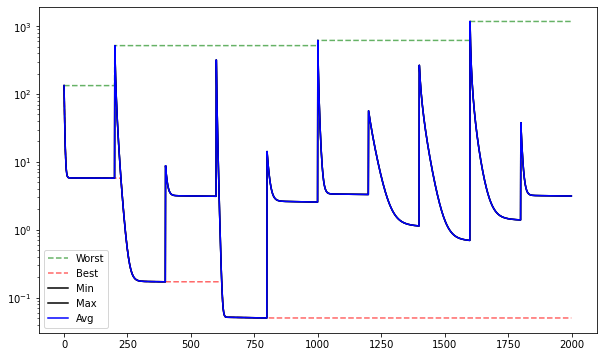

In [10]:
monitor.plot_stats()

## Búsqueda de un buen punto de inicio

In [11]:
#
# En superficies dificiles, malos puntos de inicio suelen
# llevar a malas soluciones finales, por lo que se puede
# usar una técnica como Monte Carlo para encontrar un buen
# punto de arranque
#

# Estadísticas de las corridas
monitor = Monitor()

# Cantidad de soluciones simultánteas
POPSIZE = 20

# Generador del punto aleatorio
monte_carlo = RandomUniform(
    pop_size=POPSIZE,
    low=fn.LB,
    high=fn.UB,
    seed = 123456,
)

# Genera una población inicial de soluciones
solutions = monte_carlo()

# Crea una instancia del evaluador y computa el valor de la
# función para las soluciones generadas aleatoriamente
from EAOS.fnevaluator import FnEvaluator

evaluator = FnEvaluator(fn)
solutions = evaluator(solutions)

#
# Crea una instancia del seleccionador y obtiene la mejor
# solución aleatoria encontrada
#
from EAOS.operators import SelectionBest

selectionBest = SelectionBest(k=1)
solutions = selectionBest(solutions)

#
# Aplica el algoritmo del gradiente
#
monitor(solutions)

# Número de iteraciones
NITER = 100

for iter in range(NITER):
    solutions = optimizer(solutions)
    monitor(solutions)

monitor.global_x_opt, monitor.global_fn_x_opt

(array([0.67013165, 0.44868433]), 0.10882850483979656)

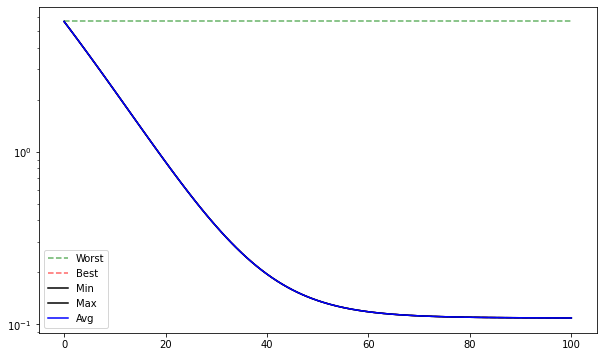

In [12]:
monitor.plot_stats()

## Experimento 1

100% (1140 of 1140) |####################| Elapsed Time: 0:08:28 Time:  0:08:28


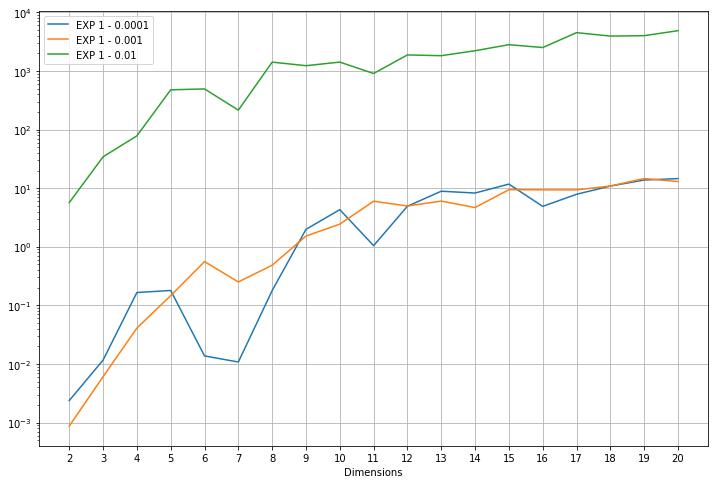

In [13]:
import progressbar

POPSIZE = 1
RESTARTS = 20
NDIMS = 20
LEARNING_RATES = [0.0001, 0.001, 0.01]
NITER = 50

select = SelectionBest(k=POPSIZE)

best_fn_x = {}

max_value = len(LEARNING_RATES) * (NDIMS - 1) * RESTARTS
counter = 0
with progressbar.ProgressBar(max_value=max_value) as bar:

    for i_learning_rate, learning_rate in enumerate(LEARNING_RATES):

        exp_name = 'EXP 1 - ' + str(learning_rate) 
        best_fn_x[exp_name] = []

        for n_dim in range(2, NDIMS+1):

            fn = Rosenbrock(n_dim=n_dim)
            evaluator = FnEvaluator(fn)
            optimizer = GradientDescendent(fn=fn, learning_rate=learning_rate)

            monitor = Monitor()

            monte_carlo = RandomUniform(
                pop_size=POPSIZE,
                low=fn.LB,
                high=fn.UB,
                seed=123456,
            )

            for restart in range(RESTARTS):

                solutions = monte_carlo()
                solutions = evaluator(solutions)
                monitor(solutions)

                for iter in range(min(500, n_dim * NITER)):
                    solutions = optimizer(solutions)
                    monitor(solutions)
                    
                counter += 1
                bar.update(counter)

            best_fn_x[exp_name].append(0.00000001 + monitor.global_fn_x_opt)

#
# Grafica los resultados
#
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(12, 8))

for k in best_fn_x.keys():
    plt.plot(list(range(2, NDIMS+1)), best_fn_x[k], label="{}".format(k))

plt.yscale("log")
plt.grid()
plt.xticks(np.arange(2, NDIMS + 1, 1))
plt.xlabel("Dimensions")
plt.legend()
plt.show()

#
# Los resultados son muy sensibles a la tasa de aprendizaje.
# Una tasa de aprendizaje más pequeña no significa que se
# encuentre un mejor punto de mínima.
#

## Experimento 2

100% (1140 of 1140) |####################| Elapsed Time: 0:08:43 Time:  0:08:43


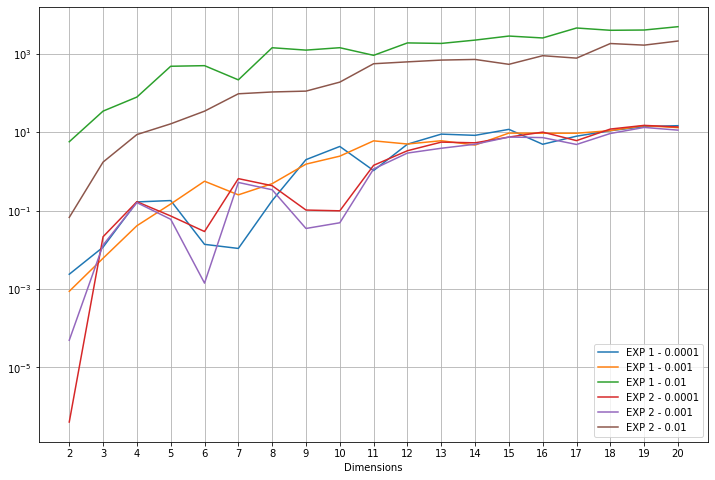

In [14]:
#
# Efecto de la búsqueda de un buent punto de inicio
#

POPSIZE = 100
RESTARTS = 20
NDIMS = 20
LEARNING_RATES = [0.0001, 0.001, 0.01]
NITER = 50

select = SelectionBest(k=POPSIZE)

max_value = len(LEARNING_RATES) * (NDIMS - 1) * RESTARTS
counter = 0
with progressbar.ProgressBar(max_value=max_value) as bar:

    for i_learning_rate, learning_rate in enumerate(LEARNING_RATES):

        exp_name = 'EXP 2 - ' + str(learning_rate) 
        best_fn_x[exp_name] = []

        for n_dim in range(2, NDIMS + 1):

            fn = Rosenbrock(n_dim=n_dim)
            evaluator = FnEvaluator(fn)
            optimizer = GradientDescendent(fn=fn, learning_rate=learning_rate)

            monitor = Monitor()

            monte_carlo = RandomUniform(
                pop_size=POPSIZE,
                low=fn.LB,
                high=fn.UB,
                seed=123456,
            )

            for restart in range(RESTARTS):

                solutions = monte_carlo()
                solutions = evaluator(solutions)
                
                #
                # Selecciona la mejor solución aleatoria
                # encontrada
                #
                solutions = selectionBest(solutions)
                
                monitor(solutions)

                for iter in range(min(500, n_dim * NITER)):
                    solutions = optimizer(solutions)
                    monitor(solutions)
                    
                counter += 1
                bar.update(counter)

            best_fn_x[exp_name].append(0.00000001 + monitor.global_fn_x_opt)

#
# Grafica los resultados
#
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(12, 8))

for k in best_fn_x.keys():
    plt.plot(list(range(2, NDIMS+1)), best_fn_x[k], label="{}".format(k))

plt.yscale("log")
plt.grid()
plt.xticks(np.arange(2, NDIMS+1, 1))
plt.xlabel("Dimensions")
plt.legend()
plt.show()

#
# Hay una clara mejoria al buscar un buen punto de 
# arranque en relación a los peores casos 
#